In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

### Домашняя работа

**Задание простого уровня** Мы говорили, что метрики качества нужны, чтобы сравнивать различные модели между собой. В задаче полиномиальной регрессии реализуйте код для выбора лучшей степени полиному:

* возьмите все степени от 1 до 10 по порядку, без пропусков.
* найдите степень полинома, где будет лучший r2-score
* напишите код, который выводит самую подходящую степень полинома и соответствующий ей скор

Эта процедура называется Grid Search и помогает найти лучшие параметры для модели.

Обучите лучшую модель и сделайте predict

In [2]:
def generate_degrees(source_data, degree: int):
    source_data = pd.DataFrame(source_data)
    new_data = pd.DataFrame()

    cols = source_data.columns

    for n in range(1, degree + 1):
      new_cols = [f'{name}^{n}' for name in cols]
      new_data[new_cols] = source_data.copy()**n

    return new_data

def test_polynomial(data, target, degree, random_state=42):

    X = generate_degrees(data, degree)
    y = target

    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=0.8, 
                                                        random_state=random_state)

    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_test)

    score = r2_score(y_test, y_pred)

    return score, model

def search_best_polynomial_degree(data, target, 
                                  min_degree: int, max_degree: int,
                                  return_best_score=False,
                                  random_state=42):
  
  best_score, best_degree = -np.inf, None

  for degree in range(min_degree, max_degree+1):
    score, model = test_polynomial(data=data, 
                                   target=target,
                                   degree=degree,
                                   random_state=random_state)

    if score > best_score:
      best_score, best_degree = score, degree
  
  if return_best_score:
    return best_degree, best_score
  else:
    return best_degree

In [3]:
data = pd.read_csv('data/non_linear.csv', sep=',')
data.head()

,x_train,y_train
0,0.138368,0.838812
1,0.157237,0.889313
2,0.188684,1.430040
3,0.685553,1.717309
4,0.874237,2.032588


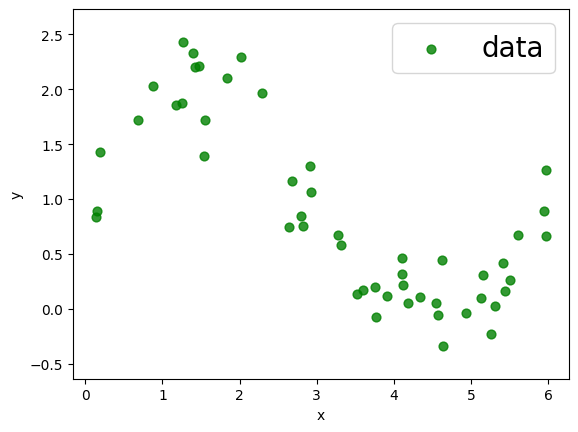

In [4]:
margin = 0.3

plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8, label='data')

plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
X = data[['x_train']]
y = data['y_train']

best_degree, best_score = search_best_polynomial_degree(X, y, 1, 10, 
                                                        return_best_score=True)

print('best_degree={},\n'
      'best_score={}'\
      .format(best_degree, best_score))

best_degree=8,
best_score=0.9043458585467707



**Задание среднего уровня** Напишите класс для обучения модели, который содержит:

* функцию `.fit(X, y)` , которая принимает на вход массив фичей `X`, массив таргетов `y` и обучает коэффициенты регрессии. Код для обучения взять из первого урока модуля *Постановка ML задачи линейной регрессии*
* функцию `.predict(X)`, которая по массиву фичей `X` возвращает массив предсказаний `y`

Нужно использовать код для аналитически вычисляемых коэффициентов. 

Это задание позволит понять, как работает линейная регрессия "внутри" библиотечной реализации.

In [6]:
class CustomLinearReg:
    def __init__(self):
        self._weights = None
    
    def fit(self, X, y):
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)

        if X.shape != y.shape:
          raise ValueError(
              'X and y have different shape: {}, {}'\
              .format(X.shape, y.shape)
            )
          
        wcol = 'w0'
        if wcol in X.columns:
          i = 0
          while i in X.columns:
            i += 1
          
          wcol = i

        X_new = pd.DataFrame(columns=[wcol]+list(X.columns))

        X_new[X.columns] = None
        X_new[X.columns] = X[X.columns]
        X_new[wcol] = 1.0

        X = X_new

        w = inv(
          (X.T).dot(X)
        ).dot(X.T).dot(y)
        
        self._weights = w
    
    def predict(self, X):
      if self._weights is None:
        raise Exception('model is not fitted')

      X = pd.DataFrame(X)

      Y_predict = self._weights[0][0] + self._weights[1][0]*X

      return Y_predict

In [7]:
model = CustomLinearReg()
x_hw = [50, 60, 70, 100]
y_hw = [10, 15, 40, 45]
model.fit(x_hw, y_hw)

In [8]:
margin = 10
X_min = min(x_hw)-margin
X_max = max(x_hw)+margin

X_support = np.linspace(X_min, X_max, num=100)
X_support = pd.DataFrame(X_support, columns = ['X'])

Y_model = model.predict(X_support)

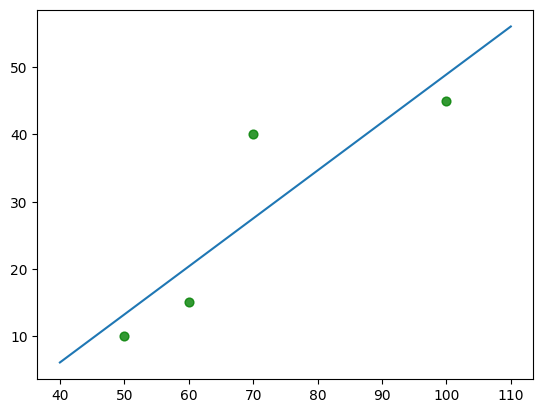

In [9]:
plt.scatter(x_hw, y_hw, 40, 'g', 'o', alpha=0.8)
plt.plot(X_support, Y_model);

**Задание высокого уровня**

1. разделите датасет с домами Бостона из Урока 2 (таргет и фичи) на две части: в одной части 80% датасета (назовём train) в другой 20% (назовём valid) с помощью функции `train_test_split` из библиотеки `sklearn`
1. обучите модель только на train датасете
1. постройте предсказания valid датасете
1. Посчитайте  `r2 score` на валидационном сете

После этого примените к обеим датасетам z-преобразование и повторите шаги 2-4. Как изменилась метрика r2?

Это задание поможет понять, как валидировать линейную регрессию (и другие модели) на отложенной выборке.

In [10]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(data, target, 
                                                    train_size=0.8, 
                                                    random_state=42)

model = LinearRegression()
model.fit(x_train, y_train);

In [12]:
y_pred = model.predict(x_valid)
score = r2_score(y_valid, y_pred)
score

0.6687594935356325

In [19]:
std_scaler = StandardScaler()
std_x_train = std_scaler.fit_transform(x_train)

std_scaler = StandardScaler()
std_x_valid = std_scaler.fit_transform(x_valid)

In [20]:
model = LinearRegression()
model.fit(std_x_train, y_train);

In [21]:
y_pred = model.predict(std_x_valid)
score = r2_score(y_valid, y_pred)
score

0.6262727067493521

*После преобразования значение метрики r2 ухудшилось*